In [ ]:
import os
import numpy as np
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Masking
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical


In [ ]:
# ==== CONFIG ====
DATA_DIR = "/content/dataset"
SEQ_LEN = 60 # 2 seconds
NUM_CLASSES = 10
INPUT_DIM = 63  # 1 hands x 21 landmarks x 3 coords
AUGMENT_TIMES = 15  # How many augmented samples per original sample
VAL_AUGMENT_TIMES = 2

# ==== 1. Load and preprocess ====
import re

def load_data(data_dir):
    X_train, y_train = [], []
    X_val, y_val = [], []

    label_map = {}
    label_idx = 0

    for file in os.listdir(data_dir):
        if not file.endswith(".npy"):
            continue

        filepath = os.path.join(data_dir, file)
        name = file.replace(".npy", "")
        parts = name.split("_")
        if len(parts) < 2:
            continue

        label_name = parts[0]
        split_type_raw = parts[1]

        # Match "train", "train1", "train99", etc.
        if re.match(r"^train", split_type_raw):
            split_type = "train"
        elif re.match(r"^val", split_type_raw):
            split_type = "val"
        else:
            print(f"Skipping {file}: split type not recognized.")
            continue

        # Assign numeric label
        if label_name not in label_map:
            label_map[label_name] = label_idx
            label_idx += 1

        try:
            arr = np.load(filepath)
            # Pad or crop to SEQ_LEN
            if arr.shape[0] < SEQ_LEN:
                pad = np.zeros((SEQ_LEN - arr.shape[0], arr.shape[1]))
                arr = np.vstack((arr, pad))
            else:
                arr = arr[:SEQ_LEN]

            if split_type == "train":
                X_train.append(arr)
                y_train.append(label_map[label_name])
            elif split_type == "val":
                X_val.append(arr)
                y_val.append(label_map[label_name])
        except Exception as e:
            print(f"Skipping file {file}: {e}")

    return (np.array(X_train), to_categorical(y_train, num_classes=len(label_map)),
            np.array(X_val), to_categorical(y_val, num_classes=len(label_map)),
            label_map)


print("Loading data...")
# Load and split data into train and validation sets
X_train, y_train, X_val, y_val, label_map = load_data(DATA_DIR)
print(f"Loaded {len(X_train)} training samples and {len(X_val)} validation samples.")

# ==== 1. Encode labels ====
encoder = LabelEncoder()

print(X_train[0])


Loading data...
Loaded 70 training samples and 20 validation samples.
[[ 0.1715717   0.34574141  0.02550579 ... -0.02521637  0.17511882
  -0.00180974]
 [ 0.17140932  0.34730411  0.02433795 ... -0.02642716  0.17479265
  -0.00149199]
 [ 0.17194694  0.34674866  0.02464783 ... -0.02650416  0.17378087
  -0.00324943]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
# ==== Augmentation Functions ====

def add_noise(x, std=0.002):
    noise = np.random.normal(0, std, x.shape)
    return x + noise

def time_shift(x, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift + 1)
    if shift > 0:
        x = np.pad(x, ((shift, 0), (0, 0)), mode='constant')[:SEQ_LEN]
    elif shift < 0:
        x = np.pad(x, ((0, -shift), (0, 0)), mode='constant')[-SEQ_LEN:]
    return x

def random_scale(x, min_scale=0.01, max_scale=0.1):
    scale = np.random.uniform(min_scale, max_scale)
    return x * scale

def temporal_dropout(x, drop_prob=0.1):
    mask = np.random.rand(x.shape[0]) > drop_prob
    mask = mask[:, np.newaxis]  # for broadcasting
    return x * mask

def rotate_z(x, max_angle=20):
    reshaped = x.reshape(-1, 3)
    theta = np.radians(np.random.uniform(-max_angle, max_angle))
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])
    rotated = reshaped @ rot_matrix.T
    return rotated.reshape(x.shape)

# === Different augmentation logic for training and validation ===

def augment_sample_train(x):
    x = add_noise(x)
    x = time_shift(x)
    x = random_scale(x)
    x = temporal_dropout(x)
    x = rotate_z(x)
    return x

def augment_sample_val(x):
    x = time_shift(x, max_shift=3)  # Light shift
    x = rotate_z(x, max_angle=5)   # Light rotation
    return x

def augment_dataset(X, y, times=2, mode='train'):
    X_aug, y_aug = [], []
    for i in range(len(X)):
        for _ in range(times):
            aug = augment_sample_train(X[i]) if mode == 'train' else augment_sample_val(X[i])
            X_aug.append(aug)
            y_aug.append(y[i])
    return np.array(X_aug), np.array(y_aug)


print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

print("Augmenting training data...")
X_train_aug, y_train_aug = augment_dataset(X_train, y_train, times=AUGMENT_TIMES, mode='train')

print("Augmenting validation data...")
X_val_aug, y_val_aug = augment_dataset(X_val, y_val, times=VAL_AUGMENT_TIMES, mode='val')

# Combine original + augmented
X_train_combined = np.concatenate([X_train, X_train_aug])
y_train_combined = np.concatenate([y_train, y_train_aug])

X_val_combined = np.concatenate([X_val, X_val_aug])
y_val_combined = np.concatenate([y_val, y_val_aug])

# Shuffle training set (not validation)
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)


Training samples: 70, Validation samples: 20
Augmenting training data...
Augmenting validation data...


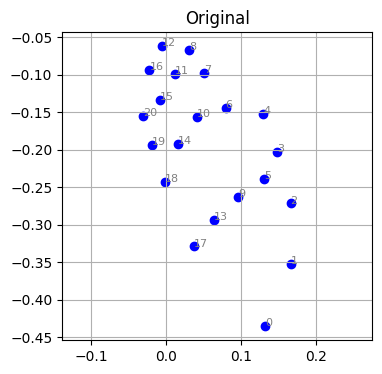

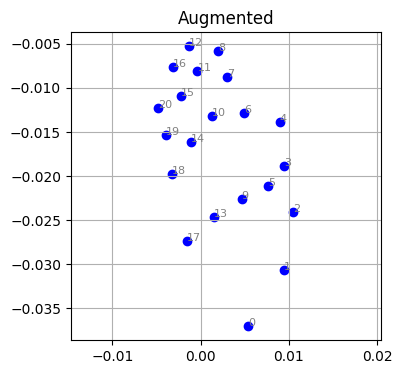

In [ ]:
import matplotlib.pyplot as plt

def plot_hand_sequence(seq, title=""):
    """Plot 21 landmarks in 2D from a single frame in a sequence."""
    frame = seq[0]  # Use first frame
    coords = frame.reshape(-1, 3)  # (21, 3)
    xs, ys = coords[:, 0], -coords[:, 1]  # Invert Y for visual consistency

    plt.figure(figsize=(4, 4))
    plt.scatter(xs, ys, c='blue')
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(i), fontsize=8, color='gray')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# === Example: original vs augmented
sample_id = 7
original = X_train[sample_id]
augmented = augment_sample_train(original)

plot_hand_sequence(original, title="Original")
plot_hand_sequence(augmented, title="Augmented")

In [ ]:
# ==== Build Bidirectional LSTM Model ====
model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(16)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# ==== Train with augmented datasets ====
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val_combined, y_val_combined),
    epochs=13,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_30                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1124 - loss: 2.2993 - val_accuracy: 0.2500 - val_loss: 2.1826
Epoch 2/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2086 - loss: 2.2485 - val_accuracy: 0.2167 - val_loss: 2.0922
Epoch 3/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2581 - loss: 2.0830 - val_accuracy: 0.3000 - val_loss: 1.9566
Epoch 4/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3541 - loss: 1.8460 - val_accuracy: 0.3500 - val_loss: 1.8085
Epoch 5/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4133 - loss: 1.6998 - val_accuracy: 0.3667 - val_loss: 1.6629
Epoch 6/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4505 - loss: 1.5347 - val_accuracy: 0.3833 - val_loss: 1.5352
Epoch 7/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5395 - loss: 1.4261 - val_accuracy: 0.5167 - val_loss: 1.4323
Epoch 8/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5802 - loss: 1.3930 - val_accuracy: 0.5333 - v

In [ ]:
model.save("sign_language_model.keras")

In [ ]:
print("Label map (label → index):")
for label, index in label_map.items():
    print(f"{index}: {label}")

Label map (label → index):
0: hello
1: thanks
2: no
3: smart
4: need
5: find
6: fuck
7: me
8: home
9: yes


In [ ]:
import collections
print("Train:", collections.Counter(np.argmax(y_train, axis=1)))
print("Val:", collections.Counter(np.argmax(y_val, axis=1)))


Train: Counter({np.int64(1): 7, np.int64(3): 7, np.int64(4): 7, np.int64(5): 7, np.int64(2): 7, np.int64(6): 7, np.int64(7): 7, np.int64(8): 7, np.int64(9): 7, np.int64(0): 7})
Val: Counter({np.int64(0): 2, np.int64(2): 2, np.int64(1): 2, np.int64(7): 2, np.int64(9): 2, np.int64(8): 2, np.int64(4): 2, np.int64(6): 2, np.int64(3): 2, np.int64(5): 2})


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), target_names=label_map.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
              precision    recall  f1-score   support

       hello       1.00      1.00      1.00         2
      thanks       1.00      0.50      0.67         2
          no       1.00      1.00      1.00         2
       smart       0.67      1.00      0.80         2
        need       1.00      0.50      0.67         2
        find       1.00      1.00      1.00         2
        fuck       1.00      1.00      1.00         2
          me       0.67      1.00      0.80         2
        home       1.00      0.50      0.67         2
         yes       0.67      1.00      0.80         2

    accuracy                           0.85        20
   macro avg       0.90      0.85      0.84        20
weighted avg       0.90      0.85      0.84        20

